In [25]:
import time
import pandas as pd
import os.path
import numpy as np
import scipy.stats as stats
from keras.callbacks import History


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sys import argv
import json
import joblib


In [3]:
def read_raw_workload_csv(filepath) -> pd.DataFrame:
    """Read and clean csv workload from filepath"""
    file_exists = os.path.exists(filepath)
    
    if not file_exists:
        raise FileNotFoundError
        return
    names = ['id','timestamp','rt','instance','service']
    
    df = pd.read_csv(filepath, names=names, skiprows=1)
    
    # drop id column
    df.drop('id', axis=1, inplace=True)
        
    # s -> ms for rt column
    # df['rt'] = df['rt']*1000
    
    return df

In [4]:
workloads = ['workload_1_sim.csv',
             'workload_2_sim.csv',
             'workload_3_sim.csv',
             'workload_4_sim.csv',
             'workload_5_sim.csv',
             'workload_6_sim.csv',
             'workload_7_sim.csv']

base_path = "../postgres/data/"

def load_workloads(workloads):
    """Loads and combine a list of workloads"""
    df = read_workload_csv(f"{base_path}{workloads[0]}")
    
    for workload in workloads[1:]:
        df_tmp = read_workload_csv(f"{base_path}{workload}")
        
        df = pd.concat([df, df_tmp])
    
    return df
        

In [46]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dfi = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dfi.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dfi.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [128]:
df = load_workloads(workloads)
df.set_index(pd.to_datetime(df['timestamp']), inplace=True)
df.drop('timestamp', axis=1, inplace=True)
df['rt'] = df['rt']*1000


# OUTLIERS ELIMINATION WITH Z-VALUE
# The z-value (standard score) gives you an idea of how far from the mean a data point is.
# But more technically it’s a measure of how many standard deviations below or above the population
# mean a raw score is.
df = df[(np.abs(stats.zscore(df['rt'])) < 2)]
print(f"Shape: {df.shape}")
df.head()

Shape: (60113, 3)


,rt,instance,service
timestamp,,,
2022-05-12 00:00:12.406070845,1596.928,ml_sd_tradeoff_user_2,user
2022-05-12 00:11:21.820067875,919.835,ml_sd_tradeoff_user_3,user
2022-05-12 00:11:30.344605124,2027.264,ml_sd_tradeoff_catalogue_3,catalogue
2022-05-12 00:17:48.129753703,2794.930,ml_sd_tradeoff_catalogue_4,catalogue
2022-05-12 00:20:55.616117535,1537.596,ml_sd_tradeoff_user_1,user


In [129]:
dfs = {service_name: df_service for service_name, df_service in df.groupby(['service'])}

In [130]:
file_names = []

In [131]:
histories = {}

(4669, 3)

,rt,instance,service
timestamp,,,
2022-05-12 00:21:36.775864892,1100.056,ml_sd_tradeoff_carts_4,carts
2022-05-12 00:38:54.670457366,1566.531,ml_sd_tradeoff_carts_3,carts
2022-05-12 00:47:21.973152811,471.104,ml_sd_tradeoff_carts_4,carts
2022-05-12 01:08:09.088733587,470.362,ml_sd_tradeoff_carts_4,carts
2022-05-12 01:25:11.404826969,970.871,ml_sd_tradeoff_carts_5,carts


5

(4306, 5)

rt                         \
instance            ml_sd_tradeoff_carts_1 ml_sd_tradeoff_carts_2   
timestamp                                                           
2022-05-12 00:21:00                    0.0                    0.0   
2022-05-12 00:38:00                    0.0                    0.0   
2022-05-12 00:47:00                    0.0                    0.0   
2022-05-12 01:08:00                    0.0                    0.0   
2022-05-12 01:25:00                    0.0                    0.0   

                                                                   \
instance            ml_sd_tradeoff_carts_3 ml_sd_tradeoff_carts_4   
timestamp                                                           
2022-05-12 00:21:00                  0.000               1100.056   
2022-05-12 00:38:00               1566.531                  0.000   
2022-05-12 00:47:00                  0.000                471.104   
2022-05-12 01:08:00                  0.000                470.362   
2022-05-12 01:25:00                  0.000                  0.000   

                                            
instance            ml_sd_tradeoff_carts_5  
timestamp                                   
2022-05-12 00:21:00                  0.000  
2022-05-12 00:38:00                  0.000  
2022-05-12 00:47:00                  0.000  
2022-05-12 01:08:00                  0.000  
2022-05-12 01:25:00                970.871

array([[0.        , 0.        , 0.        , 0.31225032, 0.        ],
       [0.        , 0.        , 0.45626922, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.13372262, 0.        ],
       ...,
       [0.        , 0.09406   , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.12648626],
       [0.        , 0.        , 0.        , 0.        , 0.06810903]])

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
10,0.0,0.0,0.000000,0.312250,0.000000,0.0,0.0,0.456269,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.148328,0.000000,0.000000,0.000000,0.000000,0.141881
11,0.0,0.0,0.456269,0.000000,0.000000,0.0,0.0,0.000000,0.133723,0.000000,...,0.000000,0.000000,0.0,0.000000,0.141881,0.000000,0.000000,0.000000,0.187136,0.000000
12,0.0,0.0,0.000000,0.133723,0.000000,0.0,0.0,0.000000,0.133512,0.000000,...,0.000000,0.000000,0.0,0.187136,0.000000,0.408412,0.000000,0.000000,0.000000,0.000000
13,0.0,0.0,0.000000,0.133512,0.000000,0.0,0.0,0.000000,0.000000,0.376337,...,0.408412,0.000000,0.0,0.000000,0.000000,0.000000,0.326356,0.000000,0.000000,0.000000
14,0.0,0.0,0.000000,0.000000,0.376337,0.0,0.0,0.000000,0.000000,0.210304,...,0.000000,0.326356,0.0,0.000000,0.000000,0.000000,0.000000,0.193572,0.000000,0.000000


(3007, 55)

(1289, 55)

(3007, 50)

(3007, 5)

(1289, 50)

(1289, 5)

(3007, 10, 5)

(1289, 10, 5)

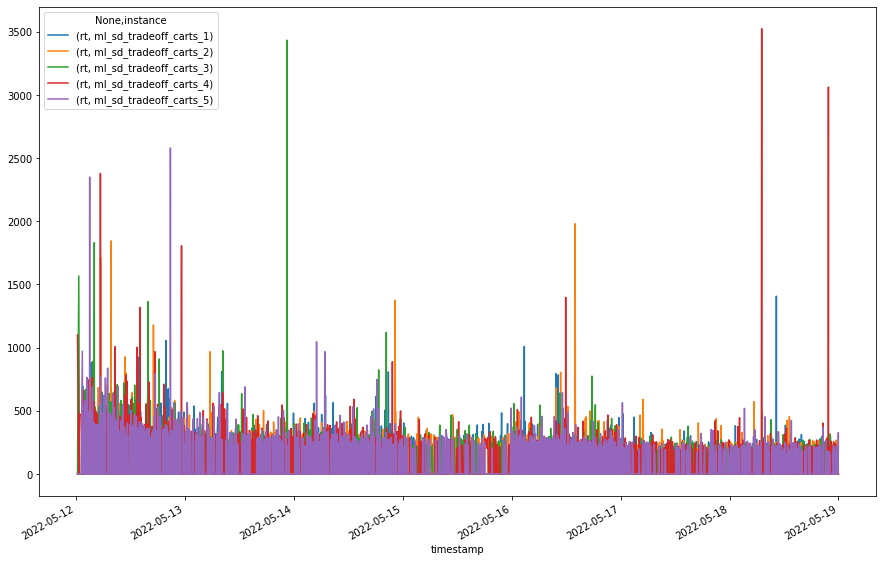

In [135]:
# TESTS
# retrieve sub dataset
sub_df = dfs['carts']
display(sub_df.shape)
display(sub_df.head())

# retrieve number instances
n_instances = sub_df['instance'].nunique()
display(n_instances)

# convert dataset in a compliant time series format
grouper = sub_df.groupby([pd.Grouper(freq='1T'), 'instance'])
sub_df_ts = grouper.mean().unstack().fillna(0)
display(sub_df_ts.shape)
display(sub_df_ts.head())

sub_df_ts.plot()

## DEFINE VARIABLES
num_forecasts = 1
# specify the number of lag hours
prev_steps = 10

# normalize features
values = sub_df_ts.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
display(scaled)

# frame as supervised learning
reframed = series_to_supervised(scaled, prev_steps, num_forecasts)
values = reframed.values
display(reframed.head())

# split into train and test sets
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
display(train.shape)
display(test.shape)

# split into input and outputs
n_obs = prev_steps * n_instances
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]

df_train_X = pd.DataFrame(train_X)
display(train_X.shape, train_y.shape)
display(test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], prev_steps, n_instances))
test_X = test_X.reshape((test_X.shape[0], prev_steps, n_instances))
display(train_X.shape)
display(test_X.shape)

In [137]:
display(sub_df_ts)

rt                         \
instance            ml_sd_tradeoff_carts_1 ml_sd_tradeoff_carts_2   
timestamp                                                           
2022-05-12 00:21:00                  0.000                  0.000   
2022-05-12 00:38:00                  0.000                  0.000   
2022-05-12 00:47:00                  0.000                  0.000   
2022-05-12 01:08:00                  0.000                  0.000   
2022-05-12 01:25:00                  0.000                  0.000   
...                                    ...                    ...   
2022-05-18 23:49:00                  0.000                  0.000   
2022-05-18 23:51:00                176.399                  0.000   
2022-05-18 23:54:00                  0.000                186.158   
2022-05-18 23:58:00                  0.000                  0.000   
2022-05-18 23:59:00                  0.000                  0.000   

                                                                   \
instance            ml_sd_tradeoff_carts_3 ml_sd_tradeoff_carts_4   
timestamp                                                           
2022-05-12 00:21:00                  0.000               1100.056   
2022-05-12 00:38:00               1566.531                  0.000   
2022-05-12 00:47:00                  0.000                471.104   
2022-05-12 01:08:00                  0.000                470.362   
2022-05-12 01:25:00                  0.000                  0.000   
...                                    ...                    ...   
2022-05-18 23:49:00                  0.000                  0.000   
2022-05-18 23:51:00                  0.000                  0.000   
2022-05-18 23:54:00                  0.000                  0.000   
2022-05-18 23:58:00                  0.000                  0.000   
2022-05-18 23:59:00                  0.000                  0.000   

                                            
instance            ml_sd_tradeoff_carts_5  
timestamp                                   
2022-05-12 00:21:00                  0.000  
2022-05-12 00:38:00                  0.000  
2022-05-12 00:47:00                  0.000  
2022-05-12 01:08:00                  0.000  
2022-05-12 01:25:00                970.871  
...                                    ...  
2022-05-18 23:49:00                209.553  
2022-05-18 23:51:00                  0.000  
2022-05-18 23:54:00                  0.000  
2022-05-18 23:58:00                326.308  
2022-05-18 23:59:00                175.707  

[4306 rows x 5 columns]

<AxesSubplot:xlabel='timestamp'>

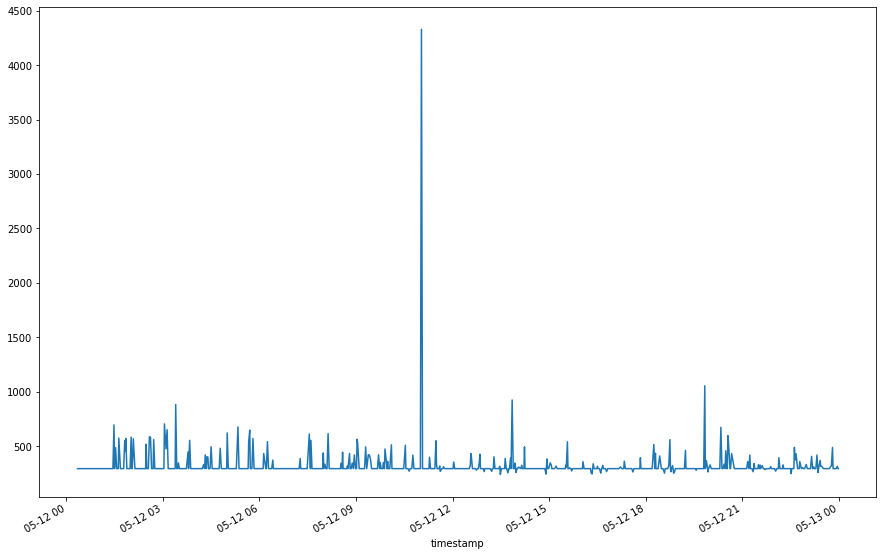

In [127]:
sub_df_ts.loc['2022-05-12']['rt','ml_sd_tradeoff_carts_1'].plot()


In [38]:
for key in dfs:
    # retrieve sub dataset
    sub_df = dfs[key]

    # retrieve number instances
    n_instances = sub_df['instance'].nunique()
    # convert dataset in a compliant time series format
    grouper = sub_df.groupby([pd.Grouper(freq='1T'), 'instance'])
    sub_df_ts = grouper.mean().unstack().fillna(0)

    ## DEFINE VARIABLES
    num_forecasts = 1
    # specify the number of lag hours
    prev_steps = 10

    values = sub_df_ts.values
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, prev_steps, num_forecasts)
    values = reframed.values
    # split into train and test sets
    n_train_hours = int(len(values) * 0.7)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = prev_steps * n_instances
    train_X, train_y = train[:, :n_obs], train[:, n_obs:]
    test_X, test_y = test[:, :n_obs], test[:, n_obs:]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], prev_steps, n_instances))
    test_X = test_X.reshape((test_X.shape[0], prev_steps, n_instances))
    
    # history 
    history = History()
    
    # design network
    model = Sequential()
    model.add(LSTM(110, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(units=55))
    model.add(Dense(n_instances * num_forecasts))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[history])
        
    # save history
    histories[key] = history
    
    # save model and scaler
    model_file_name = key + '.model.sav'
    joblib.dump(model, model_file_name)
    file_names.append(model_file_name)

print(json.dumps(file_names))

Epoch 1/10
42/42 [==============================] - 3s 27ms/step - loss: 0.0018 - val_loss: 8.9426e-04
Epoch 2/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8311e-04
Epoch 3/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8480e-04
Epoch 4/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8572e-04
Epoch 5/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8617e-04
Epoch 6/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8538e-04
Epoch 7/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8478e-04
Epoch 8/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8483e-04
Epoch 9/10
42/42 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 8.8612e-04
Epoch 10/10
42/42 [==============================] - 1s 13ms/step - loss:

INFO:tensorflow:Assets written to: ram://263e5329-0ae8-4ca3-835f-bbd0c0b36968/assets


INFO:tensorflow:Assets written to: ram://263e5329-0ae8-4ca3-835f-bbd0c0b36968/assets


Epoch 1/10
86/86 [==============================] - 4s 20ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 2/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 3/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 4/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 5/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 6/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 7/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 8/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 9/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 10/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0062


INFO:tensorflow:Assets written to: ram://7b9489aa-2bbd-40f9-9d56-7f9ffd458349/assets


INFO:tensorflow:Assets written to: ram://7b9489aa-2bbd-40f9-9d56-7f9ffd458349/assets


Epoch 1/10
48/48 [==============================] - 4s 25ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 2/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 3/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 4/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 5/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 6/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 7/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 8/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 9/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 10/10
48/48 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 0.0022


INFO:tensorflow:Assets written to: ram://270adbc6-5a0f-47a7-ad91-a4ad47d7e271/assets


INFO:tensorflow:Assets written to: ram://270adbc6-5a0f-47a7-ad91-a4ad47d7e271/assets


Epoch 1/10
71/71 [==============================] - 4s 21ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 2/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0016


INFO:tensorflow:Assets written to: ram://2ef34c3c-23f0-4c6f-9611-baa500188820/assets


INFO:tensorflow:Assets written to: ram://2ef34c3c-23f0-4c6f-9611-baa500188820/assets


Epoch 1/10
63/63 [==============================] - 4s 22ms/step - loss: 0.0115 - val_loss: 0.0043
Epoch 2/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 3/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 4/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 5/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 6/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 7/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 8/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 9/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043
Epoch 10/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0043


INFO:tensorflow:Assets written to: ram://41971a48-b045-46d7-ba7d-56c6d3dda3ae/assets


INFO:tensorflow:Assets written to: ram://41971a48-b045-46d7-ba7d-56c6d3dda3ae/assets


Epoch 1/10
86/86 [==============================] - 4s 19ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 2/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 3/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 4/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 5/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 7/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 8/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 9/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 10/10
86/86 [==============================] - 1s 13ms/step - loss: 0.0053 - val_loss: 0.0051


INFO:tensorflow:Assets written to: ram://51ae1139-e2b1-4395-b2b7-64a10d4c47cc/assets


INFO:tensorflow:Assets written to: ram://51ae1139-e2b1-4395-b2b7-64a10d4c47cc/assets


["carts.model.sav", "catalogue.model.sav", "orders.model.sav", "payment.model.sav", "shipping.model.sav", "user.model.sav"]


In [24]:
histories

{'carts': <keras.callbacks.History at 0x7eff6412b850>,
 'catalogue': <keras.callbacks.History at 0x7eff28636fa0>,
 'orders': <keras.callbacks.History at 0x7eff45782cd0>,
 'payment': <keras.callbacks.History at 0x7effa40a33a0>,
 'shipping': <keras.callbacks.History at 0x7eff2b93be50>,
 'user': <keras.callbacks.History at 0x7eff2a9d2430>}

In [31]:
history=histories['catalogue']

In [39]:

def plot_history_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Plotting carts loss:


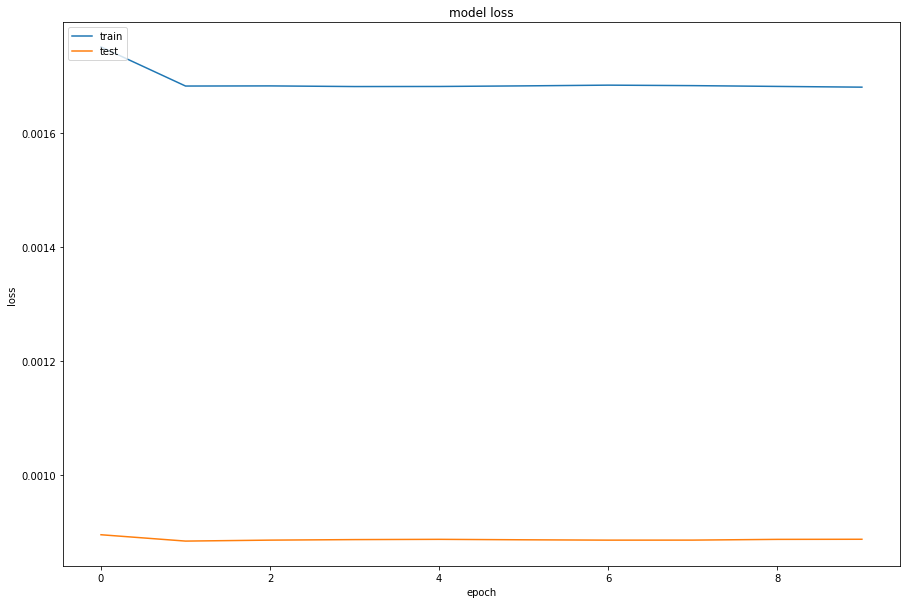

Plotting catalogue loss:


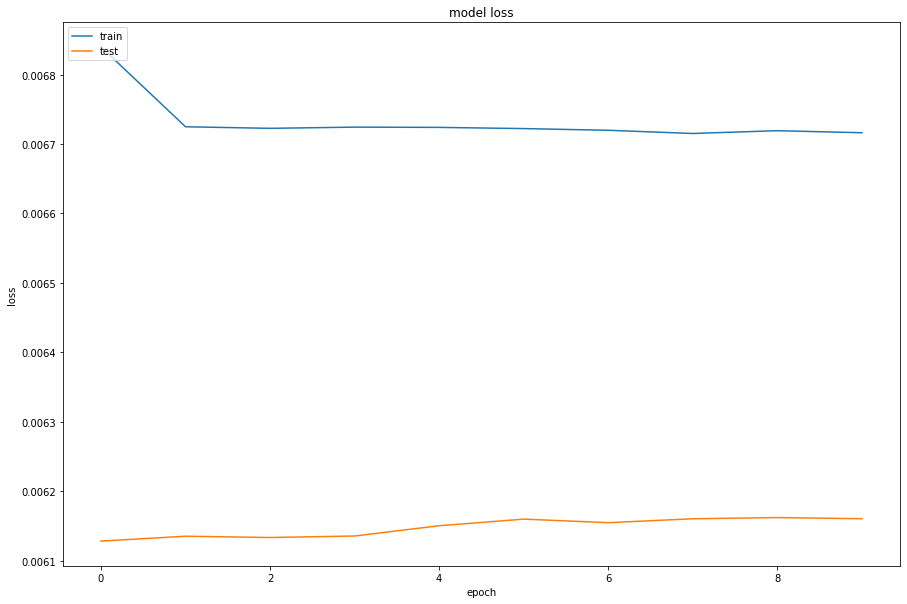

Plotting orders loss:


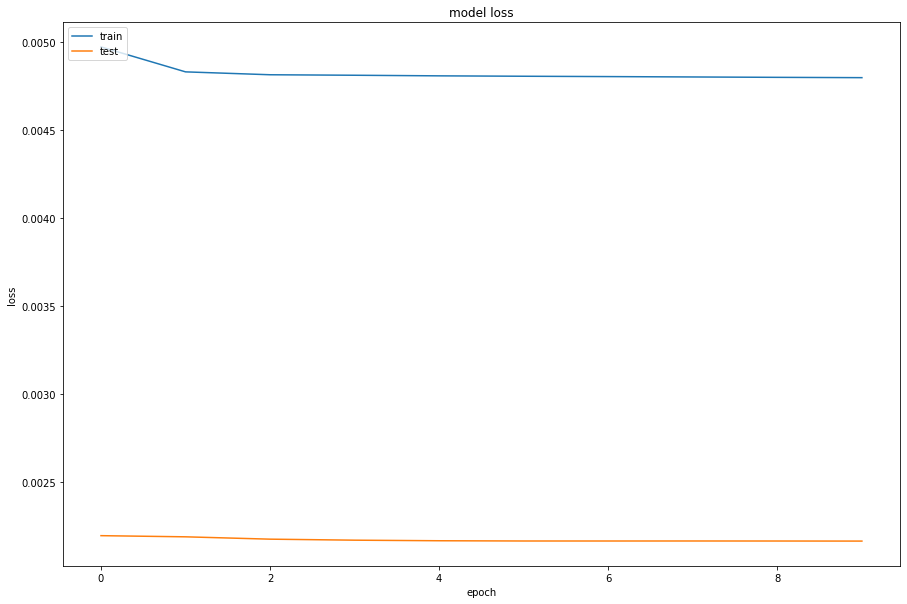

Plotting payment loss:


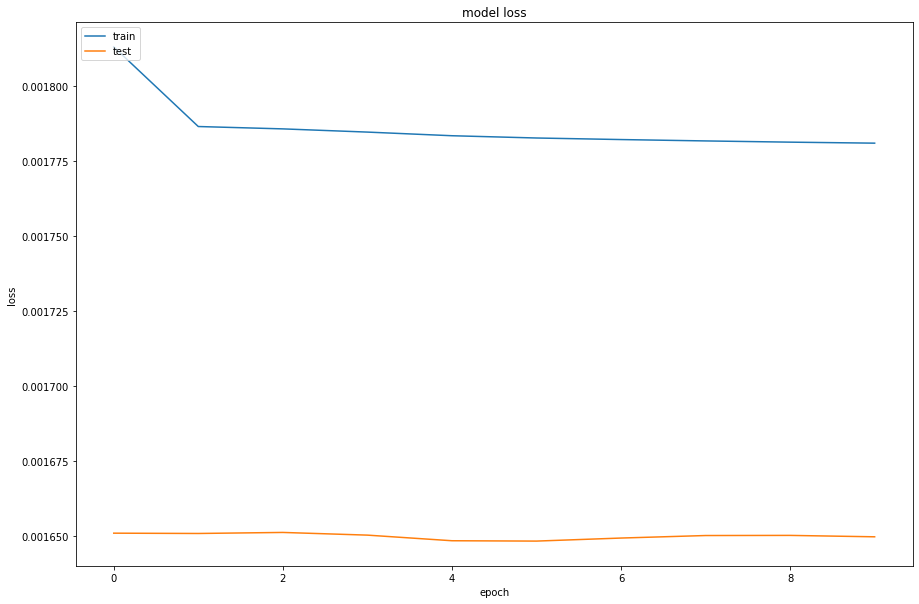

Plotting shipping loss:


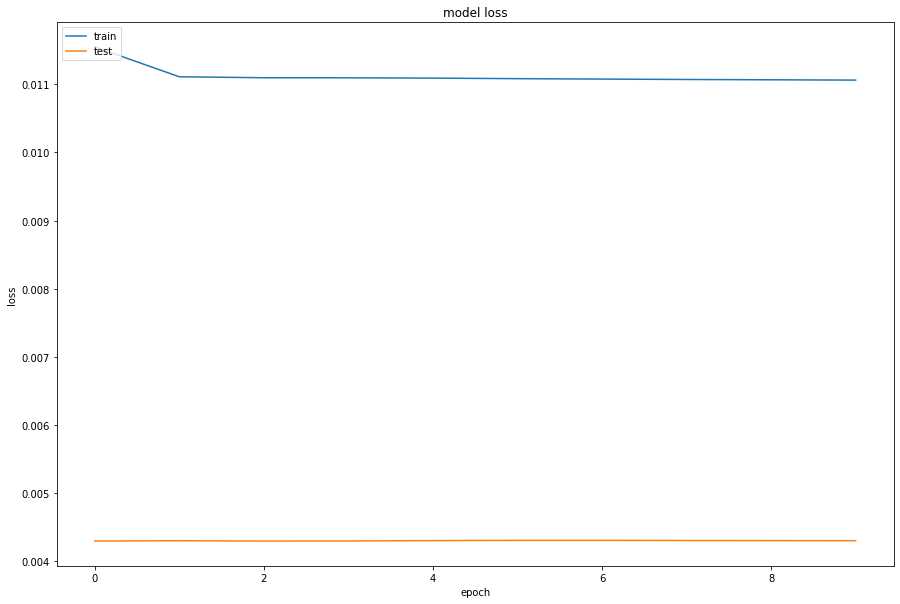

Plotting user loss:


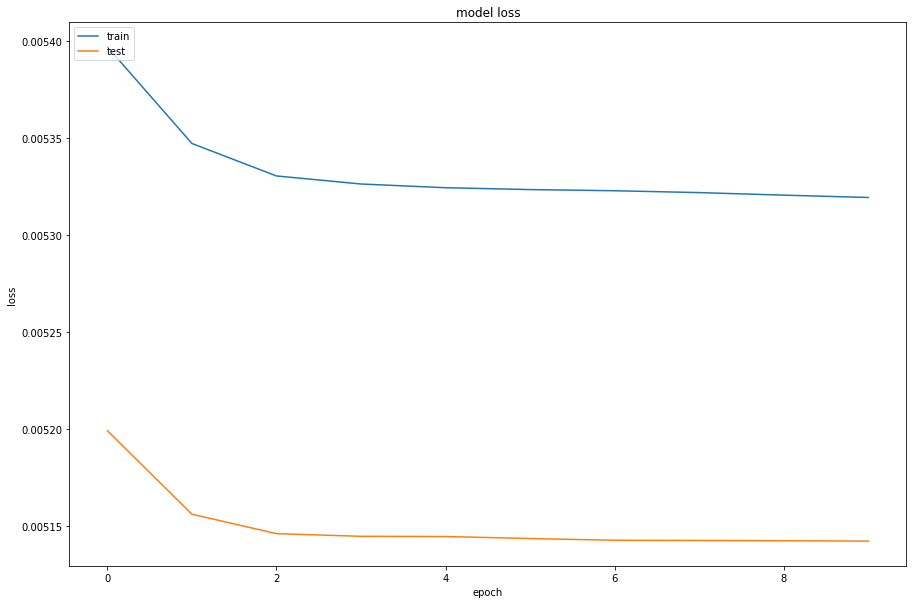

In [44]:
for k in histories:
    print(f"Plotting {k} loss:")
    plot_history_loss(histories[k])

In [6]:
payment_df = df[df['service'].str.contains('payment')]
catalogue_df = df[df['service'].str.contains('catalogue')]
shipping_df = df[df['service'].str.contains('shipping')]
order_df = df[df['service'].str.contains('order')]
carts_df = df[df['service'].str.contains('carts')]
user_df = df[df['service'].str.contains('user')]



In [42]:
# OUTLIERS ELIMINATION WITH Z-VALUE
# The z-value (standard score) gives you an idea of how far from the mean a data point is.
# But more technically it’s a measure of how many standard deviations below or above the population
# mean a raw score is.

result = payment_df[(np.abs(stats.zscore(payment_df['rt'])) < 3)]

<AxesSubplot:xlabel='timestamp'>

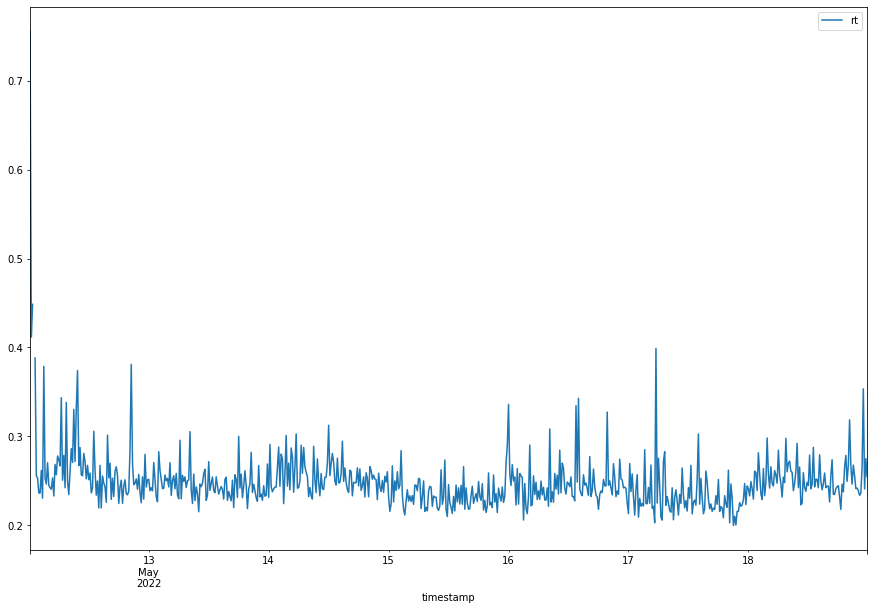

In [52]:
result.resample('15T').mean().plot()

In [18]:
p_df_1 = payment_df[payment_df['instance'].str.contains('1')]
p_df_2 = payment_df[payment_df['instance'].str.contains('2')]
p_df_3 = payment_df[payment_df['instance'].str.contains('3')]
p_df_4 = payment_df[payment_df['instance'].str.contains('4')]
p_df_5 = payment_df[payment_df['instance'].str.contains('5')]

<AxesSubplot:xlabel='timestamp'>

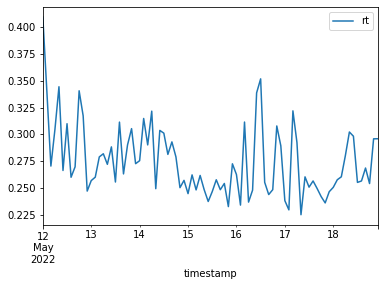

In [36]:
payment_df.resample('120T').mean().plot()

In [19]:
p_df_1.head()
p_ts_1_rt = p_df_1['rt']

p_ts_1_rt.head()

timestamp
2022-05-12 00:39:07.385261773    0.537759
2022-05-12 01:27:14.772794046    0.362848
2022-05-12 01:30:26.097054224    0.225437
2022-05-12 01:37:34.117407719    0.323133
2022-05-12 01:52:37.069251928    0.299218
Name: rt, dtype: float64

<AxesSubplot:xlabel='timestamp'>

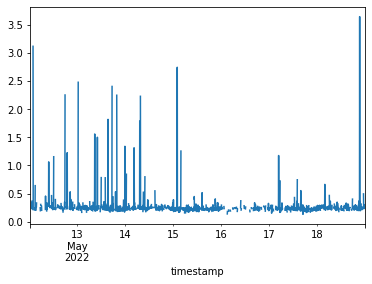

In [20]:
p_ts_1_rt.resample('5T').mean().plot()

<AxesSubplot:xlabel='timestamp'>

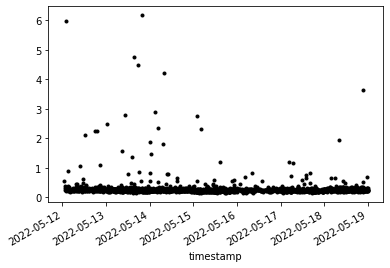

In [21]:
p_ts_1_rt.plot(style='k.')